In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install emoji wordsegment

Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
df_sainsburys = pd.read_json("../dataset/sainsburys.json")
df_sainsburys.head()

,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,matching_rules,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,possibly_sensitive,extended_entities,scopes
0,2020-12-02 21:25:42,1334247396054798336,1334247396054798336,RT @felixprojectuk: Today we collected some fo...,None,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,...,[{'tag': None}],{'created_at': 'Wed Dec 02 13:30:07 +0000 2020...,NaN,NaN,None,None,None,None,None,NaN
1,2020-03-25 08:55:11,1242736777103839237,1242736777103839237,@ocado @tesco @sainsburys @asda @waitrose @Mor...,None,"<a href=""http://twitter.com/download/iphone"" r...",True,NaN,NaN,2.015550e+07,...,[{'tag': None}],None,NaN,NaN,None,None,{'full_text': '@ocado @tesco @sainsburys @asda...,None,None,NaN
2,2020-03-15 18:07:30,1239251894293409797,1239251894293409797,RT @Danwhite1972: Dear panic buyers\n\nPlease ...,None,"<a href=""http://twitter.com/#!/download/ipad"" ...",False,NaN,NaN,NaN,...,[{'tag': None}],{'created_at': 'Sun Mar 15 08:55:18 +0000 2020...,NaN,NaN,None,None,None,None,None,NaN
3,2020-10-18 10:43:27,1317778311729369088,1317778311729369088,@daisy_haggard @sainsburys Can’t wait to see w...,"[27, 79]","<a href=""http://twitter.com/download/iphone"" r...",False,1.317512e+18,1.317512e+18,2.875019e+09,...,[{'tag': None}],None,NaN,NaN,None,None,None,None,None,NaN
4,2020-11-07 20:52:20,1325179302384717824,1325179302384717824,@lordrix @sainsburys But Sainsbury's have made...,"[21, 140]","<a href=""http://twitter.com/download/android"" ...",True,1.325169e+18,1.325169e+18,5.496380e+07,...,[{'tag': None}],None,NaN,NaN,None,None,"{'full_text': ""@lordrix @sainsburys But Sainsb...",None,None,NaN


In [5]:
# The number of missing values, the number of non-empty values, the total number and the proportion of missing values in each column are counted to generate a summary table of missing cases
null_summary = df_sainsburys.isnull().sum().to_frame(name='null_count')
null_summary['total'] = len(df_sainsburys)
null_summary['non_null_count'] = null_summary['total'] - null_summary['null_count']
null_summary['null_ratio'] = null_summary['null_count'] / null_summary['total']

# Sort the missing columns from smallest to largest to see which columns have the least missing columns
null_summary = null_summary.sort_values(by='null_ratio', ascending=True)
print(null_summary)

                           null_count  total  non_null_count  null_ratio
created_at                          0  82821           82821    0.000000
matching_rules                      0  82821           82821    0.000000
lang                                0  82821           82821    0.000000
filter_level                        0  82821           82821    0.000000
retweeted                           0  82821           82821    0.000000
favorited                           0  82821           82821    0.000000
entities                            0  82821           82821    0.000000
favorite_count                      0  82821           82821    0.000000
retweet_count                       0  82821           82821    0.000000
reply_count                         0  82821           82821    0.000000
is_quote_status                     0  82821           82821    0.000000
user                                0  82821           82821    0.000000
quote_count                         0  82821       

In [6]:
# Statistical language and proportion
lang_counts = df_sainsburys['lang'].value_counts()
lang_ratio = df_sainsburys['lang'].value_counts(normalize=True)

# Combined display
lang_summary = pd.DataFrame({
    'count': lang_counts,
    'ratio': lang_ratio
})

print(lang_summary.head(10))  

      count     ratio
lang                 
en    79136  0.955506
und    3237  0.039084
fr       82  0.000990
in       46  0.000555
tl       42  0.000507
es       39  0.000471
it       24  0.000290
et       24  0.000290
ht       23  0.000278
cy       23  0.000278


In [7]:
#Keep tweets in English and copy the data
df_sainsburys = df_sainsburys[df_sainsburys['lang'] == 'en'].copy()
print(df_sainsburys['lang'].value_counts())

lang
en    79136
Name: count, dtype: int64


In [8]:
#Extract the full tweet content (handle truncated tweets) and generate a new column：[full_text]
def extract_full_text(row):
    if row['truncated'] and isinstance(row['extended_tweet'], dict):
        return row['extended_tweet'].get('full_text', row['text'])
    return row['text']

df_sainsburys['full_text'] = df_sainsburys.apply(extract_full_text, axis=1)
print(df_sainsburys['full_text'].head(10))

0    RT @felixprojectuk: Today we collected some fo...
1    @ocado @tesco @sainsburys @asda @waitrose @Mor...
2    RT @Danwhite1972: Dear panic buyers\n\nPlease ...
3    @daisy_haggard @sainsburys Can’t wait to see w...
4    @lordrix @sainsburys But Sainsbury's have made...
5    RT @DrRJWarren: I signed the open letter askin...
6    @Sir_Loin67 I bought myself a tin  of @sainsbu...
7    Thank you for reply. Form already completed la...
8    @jojobowley @asda @sainsburys @Tesco @Morrison...
9    @sachnusun @sainsburys This is the SAME number...
Name: full_text, dtype: object


In [9]:
#Keep only the tweet ID and full text columns
df_sainsburys = df_sainsburys[['id', 'full_text']]
df_sainsburys.head()

,id,full_text
0,1334247396054798336,RT @felixprojectuk: Today we collected some fo...
1,1242736777103839237,@ocado @tesco @sainsburys @asda @waitrose @Mor...
2,1239251894293409797,RT @Danwhite1972: Dear panic buyers\n\nPlease ...
3,1317778311729369088,@daisy_haggard @sainsburys Can’t wait to see w...
4,1325179302384717824,@lordrix @sainsburys But Sainsbury's have made...


In [10]:
import re

# Regular expressions match all emojis
emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

# Check the number of emojis
emoji_count = df_sainsburys['full_text'].apply(lambda x: bool(emoji_pattern.search(str(x)))).sum()
print(f"The number of tweets containing emoji：{emoji_count}")

# Check the number of hashtags 
hashtag_count = df_sainsburys['full_text'].apply(lambda x: '#' in str(x)).sum()
print(f"The number of tweets with hashtags：{hashtag_count}")


The number of tweets containing emoji：8840
The number of tweets with hashtags：5459


In [11]:
import emoji
from wordsegment import load, segment
load() 

In [12]:
# Convert emojis to text
def demojize_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))  
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(demojize_text)

# Break a hashtag into multiple words
def split_hashtags(text):
    new_words = []
    for word in text.split():
        if word.startswith('#'):
            split_words = segment(word[1:])  
            new_words.extend(split_words)
        else:
            new_words.append(word)
    return " ".join(new_words)
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(split_hashtags)

# Break underlined words into words
def split_underscore_words(text):
    return " ".join([subword for word in text.split() for subword in word.split("_")])
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(split_underscore_words)

# Define a list of unwanted "noise words" for subsequent analysis
emoji_noise_words = {
    'tone', 'skin', 'medium', 'face', 'hand', 'person', 'type', 
    'with', 'default', 'light', 'dark', 'eye', 'eyes', 'shirt'
}

def remove_emoji_noise(text):
    return " ".join([word for word in text.split() if word.lower() not in emoji_noise_words])
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(remove_emoji_noise)

In [13]:
#All tweets are converted to lowercase for easy follow-up
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(lambda x: str(x).lower())

# Remove URLs
def remove_URLs(data):
    return re.sub('((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)',' ',data)
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(lambda x: remove_URLs(x))

# Remove punctuations
def remove_punctuations(data):
    return re.sub(r"[~.,%/:;?_&+*=!-]"," ",data)
df_sainsburys['full_text']= df_sainsburys['full_text'].apply(lambda x: remove_punctuations(x))

# Remove numbers
def remove_numbers(data):
    return re.sub('[0-9]+', '', data)
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(lambda x: remove_numbers(x))

import nltk
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    words = data.split()  
    text = [lm.lemmatize(word) for word in words] 
    return " ".join(text)
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(lambda x: lemmatizer_on_text(x))

df_sainsburys.head()

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\56553\AppData\Local\Temp\ipykernel_29816\1411626526.py:6: SyntaxWarning: invalid escape sequence '\.'
  return re.sub('((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)',' ',data)


,id,full_text
0,1334247396054798336,rt @felixprojectuk today we collected some foo...
1,1242736777103839237,@ocado @tesco @sainsburys @asda @waitrose @mor...
2,1239251894293409797,rt @danwhite dear panic buyer please use what ...
3,1317778311729369088,@daisy haggard @sainsburys can’t wait to see w...
4,1325179302384717824,@lordrix @sainsburys but sainsbury's have made...


In [14]:
import nltk 
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [15]:
# Cleaning and removing the above stop words list from the tweet text
stop_words = stopwords.words('english')
new_stopwords = {"all", "due", "to", "on", "daily", "sainsbury", "sainsburys", "sainsbury’s", "sainsbury's", "@sainsbury", "@sainsburys",
                 "sainsburys.", "sainsbury.", "s", "rt", "RT", "all", "due", "to", "on", "daily", "amp", "im", "ive", "dont", "didnt",
                 "doesnt", "cant", "couldnt", "twitter", "store", "stores", "shop", "shopping", "brand", "company", "team", "staff",
                 "employees", "business", "organization", "corporate", "today", "yesterday", "day", "week", "month", "year", "hour",
                 "minute", "second", "pm", "am", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday","one",
                 "two", "three"}
stop_words.extend(new_stopwords)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df_sainsburys['full_text'] = df_sainsburys['full_text'].apply(lambda text: cleaning_stopwords(text))
df_sainsburys['full_text'].head()

0    @felixprojectuk collected food donated shopper...
1    @ocado @tesco @asda @waitrose @morrisons time ...
2    @danwhite dear panic buyer please use humanity...
3    @daisy haggard can’t wait see brings see evil ...
4               @lordrix made 'big' thing website hel…
Name: full_text, dtype: object

In [16]:
df_sainsburys.shape

(79136, 2)

In [17]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [18]:
nltk.download('vader_lexicon')

# Initializes the VADER analyzer
sia = SentimentIntensityAnalyzer()

# Add sentiment score column
df_sainsburys['sentiment_scores'] = df_sainsburys['full_text'].apply(sia.polarity_scores)
df_sainsburys = pd.concat([df_sainsburys, df_sainsburys['sentiment_scores'].apply(pd.Series)], axis=1)

# Add sentiment label column
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_sainsburys['sentiment_label'] = df_sainsburys['compound'].apply(classify_sentiment)

print(df_sainsburys[['full_text', 'compound', 'sentiment_label']].head(10))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\56553\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                           full_text  compound sentiment_label
0  @felixprojectuk collected food donated shopper...    0.0000         neutral
1  @ocado @tesco @asda @waitrose @morrisons time ...    0.0000         neutral
2  @danwhite dear panic buyer please use humanity...    0.1027        positive
3  @daisy haggard can’t wait see brings see evil ...   -0.6597        negative
4             @lordrix made 'big' thing website hel…    0.0000         neutral
5  @drrjwarren signed open letter asking @tesco @...    0.2960        positive
6  @sir loin bought tin shortbread worst ever nee...   -0.6249        negative
7  thank reply form already completed last wait c...    0.3612        positive
8  @jojobowley @asda @tesco @morrisons @aldiuk @l...    0.3182        positive
9  @sachnusun number every customer us ha always ...    0.4019        positive


In [19]:
# Count the number and percentage of each emotion 
sentiment_counts = df_sainsburys['sentiment_label'].value_counts()
sentiment_ratio = df_sainsburys['sentiment_label'].value_counts(normalize=True) * 100

sentiment_summary = pd.DataFrame({
    'count': sentiment_counts,
    'percentage': sentiment_ratio.round(2)
})

print(sentiment_summary)

                 count  percentage
sentiment_label                   
positive         38929       49.19
neutral          23012       29.08
negative         17195       21.73


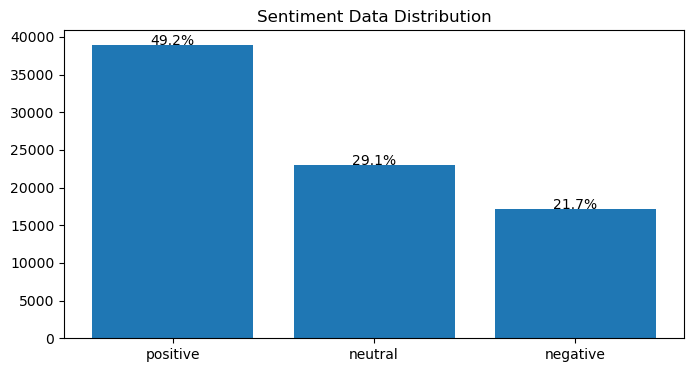

In [20]:
#Draw a bar chart of the sentiment labels and display the corresponding percentages
val_count = df_sainsburys['sentiment_label'].value_counts()
total = val_count.sum()

plt.figure(figsize=(8,4))
bars = plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

for i in range(len(bars)):
    percent = val_count.values[i] / total * 100
    plt.text(i, val_count.values[i] + 1, f"{round(percent, 1)}%", ha='center')

plt.show()

In [21]:
#The top 5 tweets with the most positive and negative emotions were extracted by mood score
top_positive = df_sainsburys.sort_values(by='compound', ascending=False).head(5)
top_negative = df_sainsburys.sort_values(by='compound').head(5)

print("Top Positive Comments:\n", top_positive[['full_text', 'compound']])
print("\nTop Negative Comments:\n", top_negative[['full_text', 'compound']])

Top Positive Comments:
                                                full_text  compound
30976  @mrbmartinbaker @josephmammaa @andyurwin multi...    0.9993
61381  well done clapping hand medium light clapping ...    0.9944
52479  @borisjohnson @downingstreet tear joy tear joy...    0.9918
66596  @y alibhai tear joy tear joy tear joy tear joy...    0.9904
3899   happy birthday nh party popper thank caring cl...    0.9900

Top Negative Comments:
                                                full_text  compound
15870  @grahamcountrys oh poc avert screaming fear sc...   -0.9910
78118  @beetlebad wa absolutely mortified especially ...   -0.9839
18358  @sickovitt @janefinney evil twisted lonely bit...   -0.9661
30323  fish feel pain unless killed straight away die...   -0.9648
56978  @madelainelucieh racist ha racist sick told ra...   -0.9578


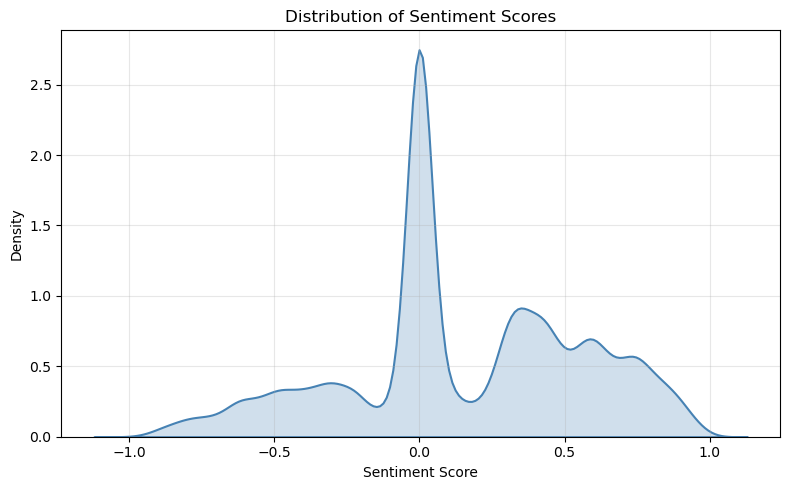

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_sainsburys, x='compound', fill=True, color='steelblue', linewidth=1.5)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

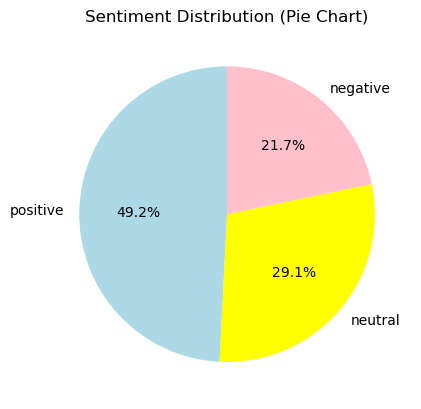

In [23]:
df_sainsburys['sentiment_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ADD8E6', 'yellow', 'pink'])
plt.ylabel('')
plt.title("Sentiment Distribution (Pie Chart)")
plt.show()

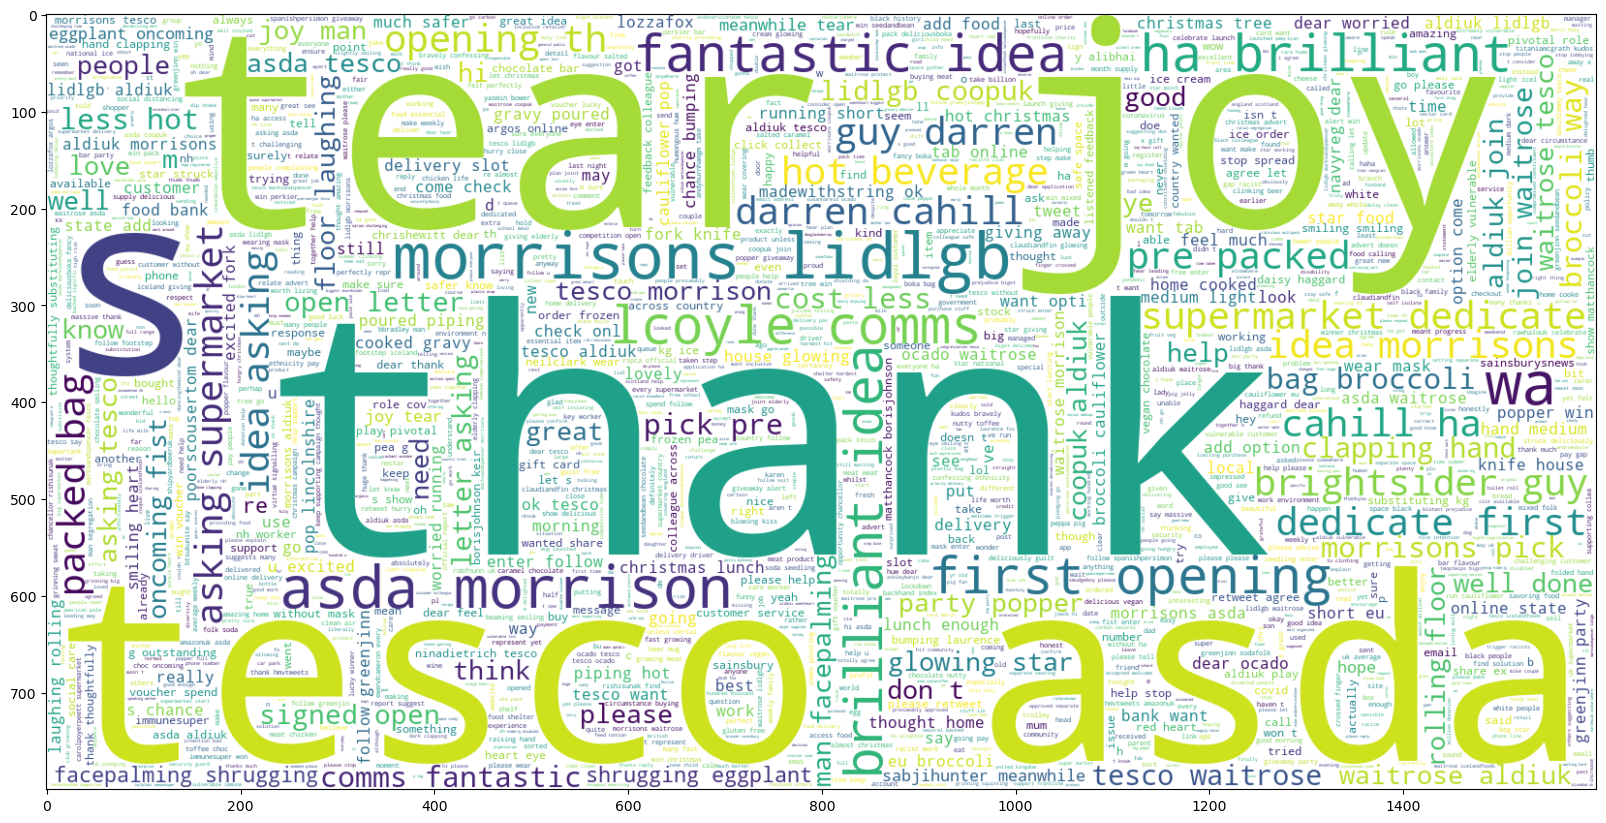

In [24]:
#Draw a positive wordcloud map
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color = 'white',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_sainsburys[df_sainsburys.sentiment_label == 'positive'].full_text))
plt.imshow(wc , interpolation = 'bilinear')

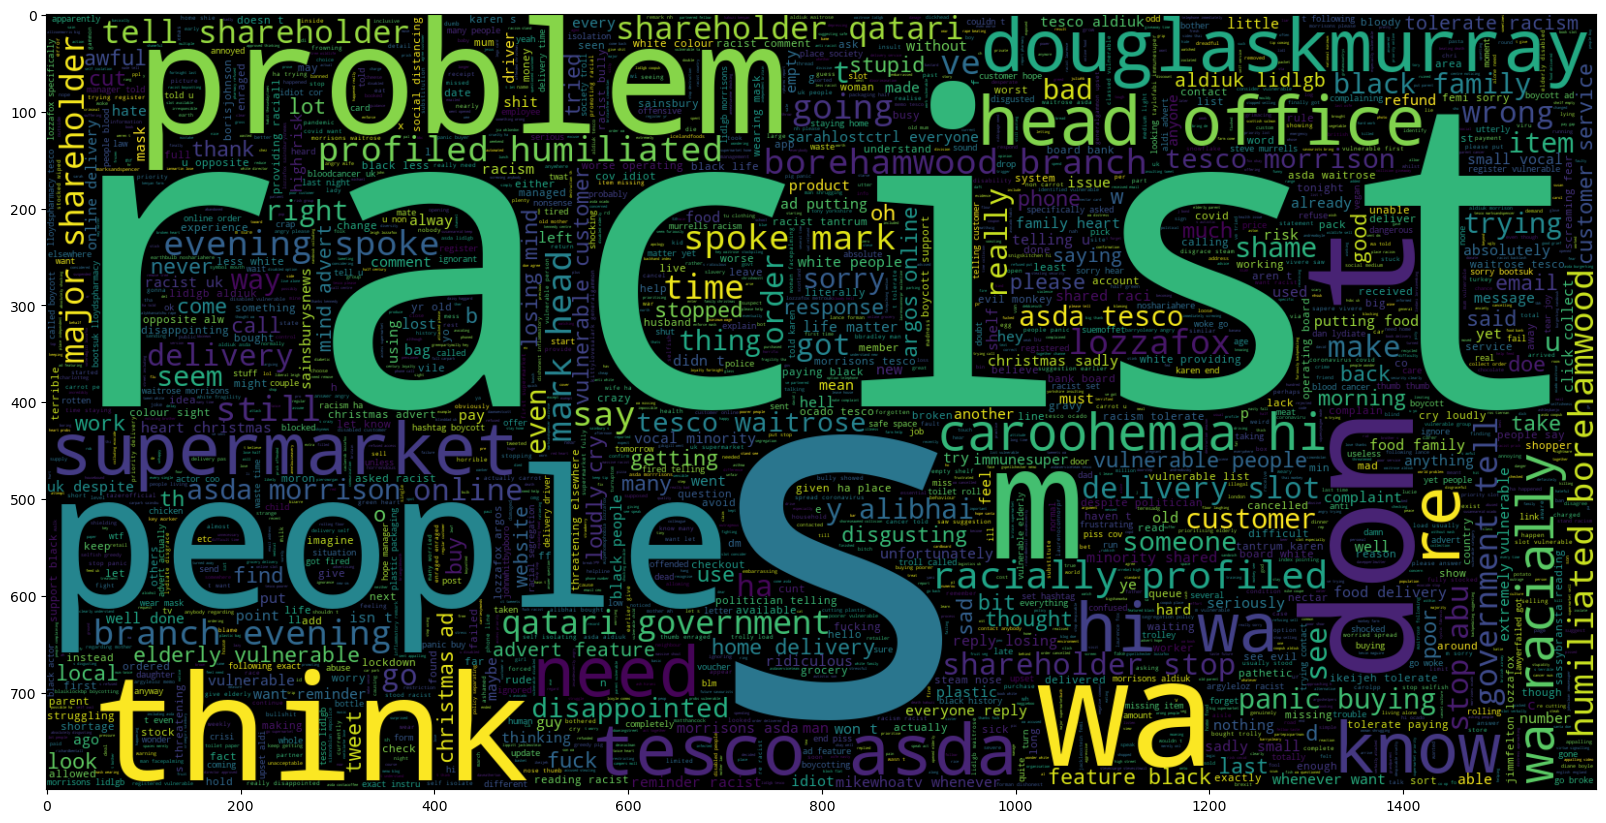

In [25]:
#Draw a negative wordcloud map
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_sainsburys[df_sainsburys.sentiment_label == 'negative'].full_text))
plt.imshow(wc , interpolation = 'bilinear')

In [26]:
!pip install -q pandas gensim pyLDAvis bertopic nltk gdown matplotlib seaborn

In [27]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\56553\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\56553\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
df_sains = pd.read_json("../dataset/sainsburys.json")

df_sains.dropna(subset=['text'], inplace=True)

In [29]:
# lowercase
df_sains['text'] = df_sains['text'].apply(lambda x: str(x).lower())

# Remove URLs
def remove_URLs(data):
    return re.sub('((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)',' ',data)
df_sains['text'] = df_sains['text'].apply(lambda x: remove_URLs(x))

# Remove punctuations
def remove_punctuations(data):
    return re.sub(r"[~.,%/:;?_&+*=!-]"," ",data)
df_sains['text']= df_sains['text'].apply(lambda x: remove_punctuations(x))

# Remove numbers
def remove_numbers(data):
    return re.sub('[0-9]+', '', data)
df_sains['text'] = df_sains['text'].apply(lambda x: remove_numbers(x))


<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\56553\AppData\Local\Temp\ipykernel_29816\2825902141.py:6: SyntaxWarning: invalid escape sequence '\.'
  return re.sub('((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)',' ',data)


In [30]:
# ==============================
# Tokenization
# ==============================
#Customize and expand the list of stop words, divide text and remove useless words
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = {"sainsbury", "sainsburys", "sainsbury’s", "sainsbury's", "@sainsbury", "@sainsburys", "sainsburys.", "sainsbury.", "s",
    "rt", "RT", "all", "due", "to", "on", "daily", "amp", "im", "ive", "dont", "didnt", "doesnt", "cant", "couldnt", "twitter", "store",
    "stores", "shop", "shopping", "brand", "company", "team", "staff", "employees", "business", "organization", "corporate", "today",
    "yesterday", "day", "week", "month", "year", "hour", "minute", "second", "pm", "am", "monday", "tuesday", "wednesday", "thursday",
                    "friday", "saturday", "sunday","one", "two", "three"}
final_stopwords = nltk_stopwords.union(custom_stopwords)

def tokenize_text(text):
    words = word_tokenize(str(text))
    return [word for word in words if word.isalnum() and word.lower() not in final_stopwords]

df_sains['tokens'] = df_sains['text'].apply(tokenize_text)

In [31]:
# Dictionaries and corpus for constructing LDA models
tokenized_texts = df_sains['tokens'].tolist()
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

Num Topics: 2, Coherence Score: 0.3577
Num Topics: 3, Coherence Score: 0.3889
Num Topics: 4, Coherence Score: 0.3287
Num Topics: 5, Coherence Score: 0.3583
Num Topics: 6, Coherence Score: 0.3012
Num Topics: 7, Coherence Score: 0.4082
Num Topics: 8, Coherence Score: 0.3964
Num Topics: 9, Coherence Score: 0.3574
Num Topics: 10, Coherence Score: 0.3388
Num Topics: 11, Coherence Score: 0.3579
Num Topics: 12, Coherence Score: 0.3708
Num Topics: 13, Coherence Score: 0.3402
Num Topics: 14, Coherence Score: 0.3364
Num Topics: 15, Coherence Score: 0.3329
Num Topics: 16, Coherence Score: 0.3388
Num Topics: 17, Coherence Score: 0.3265
Num Topics: 18, Coherence Score: 0.3022
Num Topics: 19, Coherence Score: 0.3140


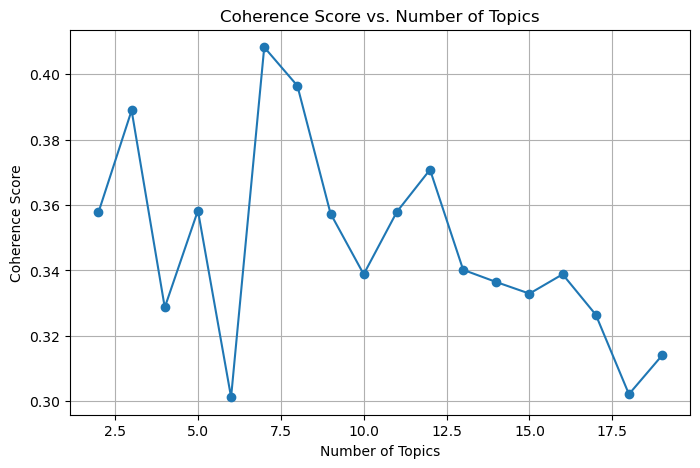

Optimal Number of Topics: 7


In [32]:
#The LDA coherence score under different topic number is calculated, and the optimal topic number is selected and visualized
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, topic_range):
    coherence_scores = []
    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            iterations=200
        )
        coherence_model = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return coherence_scores


topic_range = range(2, 20)

coherence_scores = compute_coherence_values(dictionary, corpus, tokenized_texts, topic_range)

plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

optimal_topic_num = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {optimal_topic_num}")

In [33]:
# ==============================
# Train LDA 
# ==============================
# use Optimal Number of Topics
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics= optimal_topic_num,
    random_state=42,
    passes=15,
    iterations=500,
    alpha='auto',
    eta='auto',
    minimum_probability=0.01
)

# Output LDA topics with top 10 keywords
print("\n=== LDA Topics ===")
for topic_id, words in lda_model.show_topics(num_topics=10, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, _ in words]}")

# Print the main topic of each tweet
print("\n=== Example: Dominant Topic per Tweet ===")
for i, doc_bow in enumerate(corpus[:5]):  
    topic_probs = lda_model.get_document_topics(doc_bow)
    dominant_topic = max(topic_probs, key=lambda x: x[1])
    print(f"\nTweet {i}:")
    print("Text:", df_sains['text'].iloc[i])
    print(f"Dominant Topic = {dominant_topic[0]}, Score = {dominant_topic[1]:.2f}")


=== LDA Topics ===
Topic 0: ['tesco', 'asda', 'morrisons', 'waitrose', 'aldiuk', 'lidlgb', 'coopuk', 'marksandspencer', 'icelandfoods', 'ocado']
Topic 1: ['get', 'please', 'delivery', 'help', 'vulnerable', 'online', 'food', 'hi', 'need', 'know']
Topic 2: ['like', 'lozzafox', 'uk', 'black', 'white', 'go', 'family', 'let', 'see', 'people']
Topic 3: ['want', 'add', 'slot', 'ok', 'could', 'check', 'hi', 'food', 'option', 'branch']
Topic 4: ['thank', 'thanks', 'good', 'also', 'stop', 'back', 'tell', 'yes', 'government', 'morning']
Topic 5: ['people', 'would', 'time', 'well', 'think', 'great', 'going', 'done', 'local', 'supermarkets']
Topic 6: ['idea', 'way', 'first', 'supermarkets', 'less', 'opening', 'bag', 'brilliant', 'pick', 'fantastic']

=== Example: Dominant Topic per Tweet ===

Tweet 0:
Text: rt @felixprojectuk  today we collected some food donated by shoppers at a branch of @sainsburys in alperton and we were so touched to find…
Dominant Topic = 4, Score = 0.34

Tweet 1:
Text: @oca

In [34]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score for LDA
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=df_sains['tokens'], dictionary=dictionary, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()

print(f"LDA Coherence Score: {coherence_lda:.3f}")

# LDA diversity
def calculate_lda_topic_diversity(lda_model, top_n_words=10):
    topics = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=top_n_words, formatted=False)
    unique_words = set()
    for topic in topics:
        unique_words.update([word for word, _ in topic[1]])
    return len(unique_words) / (top_n_words * lda_model.num_topics)

lda_topic_diversity = calculate_lda_topic_diversity(lda_model)
print(f"LDA Topic Diversity Score: {lda_topic_diversity:.3f}")

LDA Coherence Score: 0.377
LDA Topic Diversity Score: 0.943


In [35]:
#Use pyLDAvis to visualize the LDA model and interactively display topic distribution and keywords
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)